# G@C recycling volume per capita & G@C share of hk total

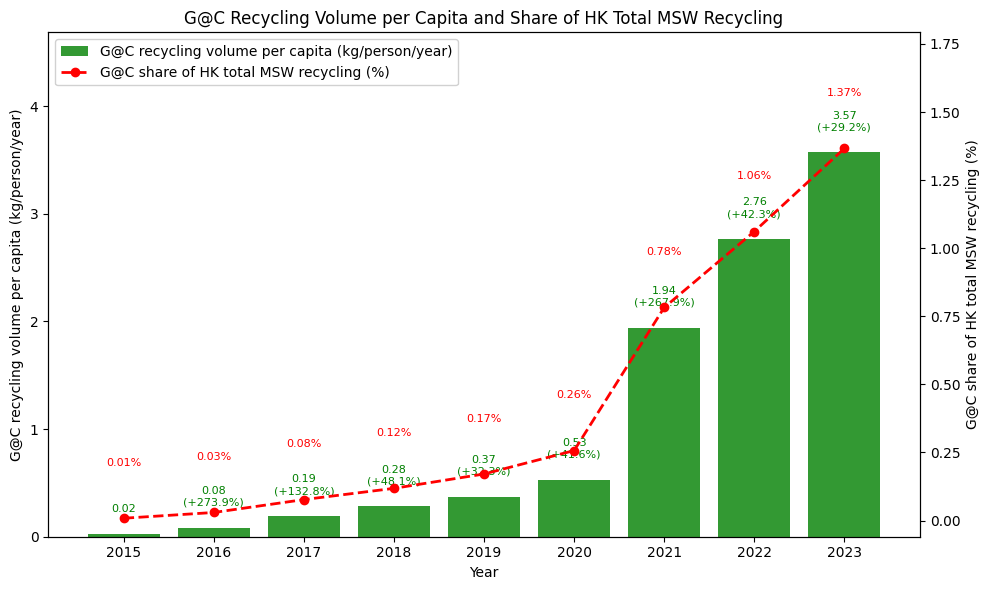

In [5]:
# !pip install pandas numpy matplotlib openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

# ---------- load data (correct sheet) ----------
data_path = Path("../General Stats_G@C_clean.xlsx")

df = pd.read_excel(
    data_path,
    sheet_name="HK MSW Volume and Recycling Rat",
    engine="openpyxl"
)

# ---------- select & clean needed columns ----------
col_volume = "G@C recyclables collection volume (tonnes)"
col_share  = "G@C share of HK total MSW recycling"
col_pop    = "HK total population (mid-year)"

# keep only rows where all 3 columns have data (drops the blank rows at top)
mask = df[col_volume].notna() & df[col_share].notna() & df[col_pop].notna()
sub = df.loc[mask, ["Year", col_volume, col_share, col_pop]].copy()

# convert volume "1,407.0" -> 1407.0 (tonnes)
sub[col_volume] = pd.to_numeric(
    sub[col_volume].astype(str).str.replace(",", ""),
    errors="coerce"
)

# convert population "7,291,300" -> 7291300
sub[col_pop] = pd.to_numeric(
    sub[col_pop].astype(str).str.replace(",", ""),
    errors="coerce"
)

# per-capita recycling volume: kg per person per year
sub["volume_kg_per_capita"] = sub[col_volume] * 1000.0 / sub[col_pop]

# year-on-year percentage change in per-capita volume
sub["pc_change_pct"] = sub["volume_kg_per_capita"].pct_change() * 100

# ----- FIX 1: correctly convert share to percentage numbers -----
# read raw numeric (remove "%" if present)
share_raw = sub[col_share].astype(str).str.rstrip("%").replace("", np.nan).astype(float)

# If the values are small (< 2), they are likely stored as fractions (e.g. 0.0137 = 1.37%),
# so multiply by 100 to get the percentage value (0.01–1.37, etc).
if share_raw.max() < 2:
    sub["share_pct"] = share_raw * 100.0
else:
    sub["share_pct"] = share_raw

# x-axis positions and labels
x = np.arange(len(sub))
x_labels = sub["Year"].astype(int).astype(str).tolist()

# ---------- plotting ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: per-capita volume (kg/person/year)
bars = ax1.bar(
    x,
    sub["volume_kg_per_capita"],
    color="green",
    alpha=0.8,
    label="G@C recycling volume per capita (kg/person/year)",
)

ax1.set_xlabel("Year")
ax1.set_ylabel("G@C recycling volume per capita (kg/person/year)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=0)

# add headroom so labels don't hit the top
y1_min, y1_max = ax1.get_ylim()
ax1.set_ylim(y1_min, y1_max * 1.25)
y1_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
offset_bar = y1_range * 0.04  # vertical gap between bar and label

# label each bar with per-capita value and % increase
for bar, value, pct in zip(bars, sub["volume_kg_per_capita"], sub["pc_change_pct"]):
    h = bar.get_height()
    if np.isnan(pct):
        label = f"{value:.2f}"
    else:
        label = f"{value:.2f}\n({pct:+.1f}%)"
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        h + offset_bar,
        label,
        ha="center",
        va="bottom",
        fontsize=8,
        color="green",
    )

# Line chart: G@C share of HK total MSW recycling (%)
ax2 = ax1.twinx()
line2, = ax2.plot(
    x,
    sub["share_pct"],
    marker="o",
    linestyle="--",
    linewidth=2,
    color="red",
    label="G@C share of HK total MSW recycling (%)",
)

ax2.set_ylabel("G@C share of HK total MSW recycling (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax2.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

# add headroom for line labels
y2_min, y2_max = ax2.get_ylim()
ax2.set_ylim(y2_min, y2_max * 1.25)
y2_range = ax2.get_ylim()[1] - ax2.get_ylim()[0]

# ----- FIX 2: more space between red point and red label -----
offset_line = y2_range * 0.10  # bigger factor than before

# label each point on the red line with its percentage value
for xi, yi in zip(x, sub["share_pct"]):
    ax2.text(
        xi,
        yi + offset_line,
        f"{yi:.2f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        color="red",
    )

# legend
lines = [bars, line2]
labels = [
    "G@C recycling volume per capita (kg/person/year)",
    "G@C share of HK total MSW recycling (%)",
]
ax1.legend(
    lines,
    labels,
    loc="upper left",
    frameon=True,
    fancybox=True,
    framealpha=0.9,
)

# title and layout
plt.title(
    "G@C Recycling Volume per Capita and Share of HK Total MSW Recycling"
)

fig.tight_layout()
plt.show()
